In [1]:
import pandas as pd
import numpy as np
import os, inspect
from RGCPD import RGCPD
from RGCPD import BivariateMI
import class_BivariateMI, functions_pp
from stat_models_cont import ScikitModel
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegressionCV
import func_models as fc_utils

%load_ext autoreload
%autoreload 2

# main directory is the directory of this notebook
main_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) 

# my main directory (which contains folders with data etc)
my_main_dir = 'C:\\Users\\alicj\\Desktop\\WORK'
data_path = os.path.join(my_main_dir, 'data')

C:\Users\alicj\AppData\Local\Continuum\anaconda3\envs\RGCPD\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Not able to load in plotting modules, check installment of networkx


# Preparing the dataset

## Load the dataset (in csv format)

In [2]:
moz_data_path = os.path.join(data_path, 'rainfall_mozambique.csv')
moz_data = pd.read_csv(moz_data_path)

In [3]:
moz_data

,Var1,Var2,1981-01-01,1981-02-01,1981-05-01,1981-06-01,1981-07-01,1981-08-01,1981-09-01,1981-10-01,...,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01
0,28.125,-29.875,140.578846,113.359550,119.096382,73.129597,33.768645,68.188021,71.626639,111.240489,...,84.622250,12.890628,22.642469,35.836739,114.083269,182.838350,267.786145,306.265346,292.665955,232.718244
1,28.375,-29.875,119.596766,104.237514,102.091419,68.381947,30.039009,67.202899,71.504189,123.109851,...,75.508513,16.258063,27.505917,36.634139,138.475532,200.023350,282.075642,275.449926,270.134886,213.400936
2,28.625,-29.875,123.081208,116.294676,91.712035,58.396470,23.470360,51.487061,67.860184,108.026460,...,76.204299,17.607618,24.315518,37.953312,145.668004,217.715252,304.715319,316.053339,314.377879,256.300624
3,28.875,-29.875,132.439956,122.415835,91.433557,52.125813,20.265874,38.829929,52.136951,91.806111,...,78.970799,12.597486,15.796919,26.027663,127.227582,215.447466,301.683798,328.231590,329.476042,292.258986
4,29.125,-29.875,159.686208,158.674257,119.053571,52.477679,20.067668,54.032621,91.329782,121.145921,...,94.318870,16.313495,21.277818,45.187807,125.221796,249.738464,340.339835,423.023625,421.182356,386.177568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4475,40.875,-10.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4476,41.125,-10.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4477,41.375,-10.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4478,41.625,-10.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Take spatial mean and convert it to xarray dataset

In [4]:
# take spatial mean
moz_mean = moz_data.mean(axis=0)

# transpose the dataframe
moz_mean = moz_mean.transpose().reset_index()

In [5]:
moz_mean

,index,0
0,Var1,35.000000
1,Var2,-20.000000
2,1981-01-01,161.746704
3,1981-02-01,221.895838
4,1981-05-01,182.742389
...,...,...
478,2020-11-01,100.733045
479,2020-12-01,280.995569
480,2021-01-01,515.899041
481,2021-02-01,668.016385


In [6]:
# select only rows with dates
moz_mean = moz_mean[2:]

Now we can note that there are missing observations from certain months. This can be a potential problem when using data from more than 1 month, hence we should add columns with $\texttt{nan}$ values for the missing months

In [7]:
40*12+3-len(moz_mean)     #data is from 01.01-1891-01.03.2021 in dd-mm-yyyy format, hence there are 40 full years and 3 months

2

We can see that the data from 2 months is missing (it is 1981-03-01 and 1981-04-01), so we will add 2 rows with $\texttt{nan}$ values, to avoid any problems with difference in timeseries lengths

In [8]:
d = {'index': ['1981-03-01', '1981-04-01'], 0: [np.nan, np.nan]}
df = pd.DataFrame(data=d)

In [9]:
frames = [moz_mean, df]
data = pd.concat(frames)

In [10]:
data['index'].sort_values()

2      1981-01-01
3      1981-02-01
0      1981-03-01
1      1981-04-01
4      1981-05-01
          ...    
478    2020-11-01
479    2020-12-01
480    2021-01-01
481    2021-02-01
482    2021-03-01
Name: index, Length: 483, dtype: object

In [11]:
moz_mean = data.sort_values(by = 'index')

In [12]:
# convert the columns to datetime objects
moz_mean['index'] = pd.to_datetime(moz_mean['index'])

In [13]:
# set variable name and drop index name
moz_mean = moz_mean.set_index('index')
moz_mean.columns = ['rainfall']
#moz_mean.index.name = None

In [14]:
moz_mean

,rainfall
index,
1981-01-01,161.746704
1981-02-01,221.895838
1981-03-01,NaN
1981-04-01,NaN
1981-05-01,182.742389
...,...
2020-11-01,100.733045
2020-12-01,280.995569
2021-01-01,515.899041


Now we have a timeseries entry for each month for each year, so we can transform it into an xarray dataset object, which we will use to create a netcdf file

In [15]:
# transform dataframe into xarray dataset
xr_moz = moz_mean.to_xarray()

In [16]:
xr_moz

<xarray.Dataset>
Dimensions:   (index: 483)
Coordinates:
  * index     (index) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-03-01
Data variables:
    rainfall  (index) float64 161.7 221.9 nan nan ... 281.0 515.9 668.0 654.9

In [17]:
# rename index 
xr_moz = xr_moz.rename({'index':'time'})

In [18]:
# add cluster
xr_moz.expand_dims('cluster')

<xarray.Dataset>
Dimensions:   (cluster: 1, time: 483)
Coordinates:
  * time      (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-03-01
Dimensions without coordinates: cluster
Data variables:
    rainfall  (cluster, time) float64 161.7 221.9 nan nan ... 515.9 668.0 654.9

In [19]:
xr_moz = xr_moz.expand_dims('cluster')

In [20]:
xr_moz['cluster'] = ('cluster', [1])

In [21]:
xr_moz

<xarray.Dataset>
Dimensions:   (cluster: 1, time: 483)
Coordinates:
  * time      (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-03-01
  * cluster   (cluster) int32 1
Data variables:
    rainfall  (cluster, time) float64 161.7 221.9 nan nan ... 515.9 668.0 654.9

In this xr_moz xarray dataset we have data from all the months, so now we will create a function to choose the data of specific month(s) from all available years 

## Function to select data from specific month(s)

In [22]:
# function that returns dataframe of specific month(s) from all available years, the input is a dataframe and a list of months, 
# e.g. for data from march and april use month([3, 4])
def month(data, month):
    return data[data.index.month.isin(month)]    

Example of choosing data from March

In [23]:
march = month(moz_mean, [3])
march.head()

,rainfall
index,
1981-03-01,NaN
1982-03-01,473.334224
1983-03-01,400.105261
1984-03-01,503.048667
1985-03-01,546.105994


Now, as the function $\texttt{month()}$ returns a dataframe we need a function that transforms the returned dataframe into an xarray dataset type

In [24]:
def xarray(data):
    xr_data = data.to_xarray()
    xr_data = xr_data.rename({'index':'time'})
    xr_data.expand_dims('cluster')
    xr_data = xr_data.expand_dims('cluster')
    xr_data['cluster'] = ('cluster', [1])
    return xr_data

This function takes as an argument a dataframe with data from specific month(s) and transforms it into an xarray Dataset

Example of converting dataframe with data from march into an xarray dataset

In [25]:
xarray(march)

<xarray.Dataset>
Dimensions:   (cluster: 1, time: 41)
Coordinates:
  * time      (time) datetime64[ns] 1981-03-01 1982-03-01 ... 2021-03-01
  * cluster   (cluster) int32 1
Data variables:
    rainfall  (cluster, time) float64 nan 473.3 400.1 ... 557.1 486.3 654.9

# Save xarray dataset as a netcdf file (nc format)

In [26]:
xr_moz.to_netcdf(os.path.join(data_path, 'rainfall_moz.nc'))

## Up till now we were taking a spatial mean and we were looking at one mean coordinate (35, -20), so we need some function/some easy way of quickly selecting area for which we want to find correlations

Questions/Problems: Can we only calculate correlations for one coordinates in the dataset? or can we choose a subset of coordinates for which we want to calculate correlations?

- create a mask with desired coordinates
- take a spatial mean using data with desired coordinates

# This function takes data, longitude and latitude as an input; data is of type dataframe and it is not transposed (so the columns are the dates and coordinates), longitude is a list of min and max longitude and latitude is a list of min and max latitude


In [27]:
def coordinates(data, lon, lat):
    lon_min = lon[0]
    lon_max = lon[1]
    lat_min = lat[0]
    lat_max = lat[1]
    
    # latitude
    data1 = data[data['Var2'] <= lat_max][data[data['Var2'] <= lat_max]['Var2'] >= lat_min]
    
    # longitude
    data2 = data1[data1['Var1'] <= lon_max][data1[data1['Var1'] <= lon_max]['Var1'] >= lon_min]
    
    return data2

We now have a function that selects data for specific coordinates, but we still need to take a spatial mean, so we create a function that creates a dataframe with values for spatial mean

In [28]:
def mean(data):
    mean_data = data.mean(axis=0)
    return mean_data

Now let's look at some example; we take our dataframe $\texttt{moz$\_$data}$ and [30, 31] as longitude and [-19, -18] as latitude

In [29]:
data_coor = coordinates(moz_data, [31, 32], [-19, -18])

In [30]:
data_coor_mean = mean(data_coor)

In [31]:
data_coor_mean

Var1           31.500000
Var2          -18.500000
1981-01-01    296.700910
1981-02-01    362.375755
1981-05-01    174.199114
                 ...    
2020-11-01    168.647104
2020-12-01    430.675962
2021-01-01    743.897615
2021-02-01    815.395393
2021-03-01    590.580979
Length: 483, dtype: float64

Now we have a series for coordinates (longitude, latitude) = (31.5, -18.5) and again we need to convert it to an xarray dataset type, we start by dropping coordinates from the data, then resetting index and giving name to our target variable of the data

In [32]:
data_coor_mean = data_coor_mean[2:]

In [33]:
data_coor_mean = data_coor_mean.reset_index()

In [34]:
# convert the columns to datetime objects
data_coor_mean['index'] = pd.to_datetime(data_coor_mean['index'])

In [35]:
data_coor_mean = data_coor_mean.set_index('index')
data_coor_mean.columns = ['rainfall']

In [36]:
data_coor_mean

,rainfall
index,
1981-01-01,296.700910
1981-02-01,362.375755
1981-05-01,174.199114
1981-06-01,70.041053
1981-07-01,7.324566
...,...
2020-11-01,168.647104
2020-12-01,430.675962
2021-01-01,743.897615


Data of this format can be used as an input to the function $\texttt{xarray()}$, which converts a dataframe to xarray dataset

In [37]:
data_coor_mean_xr = xarray(data_coor_mean)
data_coor_mean_xr

<xarray.Dataset>
Dimensions:   (cluster: 1, time: 481)
Coordinates:
  * time      (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-03-01
  * cluster   (cluster) int32 1
Data variables:
    rainfall  (cluster, time) float64 296.7 362.4 174.2 ... 743.9 815.4 590.6

As there are some steps that always needs to be taken before a dataframe can be fed into the $\texttt{xarray()}$ function, we can create a function that performs them for us

In [38]:
# data_coor is dataframe for selected coordinates, target is a string with target variable name, e.g. 'rainfall'
def data_steps(data_coor, target):
    data_coor_mean = mean(data_coor)
    data_coor_mean = data_coor_mean[2:]
    data_coor_mean = data_coor_mean.reset_index()
    data_coor_mean['index'] = pd.to_datetime(data_coor_mean['index'])
    data_coor_mean = data_coor_mean.set_index('index')
    data_coor_mean.columns = [target]
    return data_coor_mean    

In [39]:
data_coor_mean = data_steps(data_coor, 'rainfall')

In [40]:
xarray(data_coor_mean)

<xarray.Dataset>
Dimensions:   (cluster: 1, time: 481)
Coordinates:
  * time      (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-03-01
  * cluster   (cluster) int32 1
Data variables:
    rainfall  (cluster, time) float64 296.7 362.4 174.2 ... 743.9 815.4 590.6

Now that we can easily choose specific months from the data, as well as specific coordinates for which we need a forecast, we can move on to creating a pipeline

## Pipeline

The pipeline consists of the following steps:

0. selecting coordinates/months (this step is optional, if you have a dataset ready to use go to step 1)
1. function to make predictions (not yet implemented - TO DO)
2. pipeline function: 
    1. initializing BMI class
    2. initializing RGCPD function
    3. preprocessing target variable
    4. preprocessing precursor(s)
    5. splitting data into train and test
    6. calculating correlation maps
    7. clustering regions together
    8. renaming lags (optional step, but very useful)
    9. plotting correlation maps
    10. plotting significant regions
    11. getting MI timeseries (needed for prediction function)
    12. creating prediction (not yet implemented - TO DO)
3. defining paths for: target variable data, precursor(s) data, test data and output or 
4. parameter definition
    

In [41]:
def data_prep(data, m, lon, lat):
    """
    data : 
    
    month : 
    
    coor : 
    
    lon : 
    
    lat : 
    
    name : 
    
    target : 
    
    
    Returns:
    """
    data_c = coordinates(data, lon, lat)
    data_c_mean = mean(data_c)[2:].reset_index()
    
    # this step is manual, here we add the missing values
    d = {'index': ['1981-03-01', '1981-04-01'], 0: [np.nan, np.nan]}
    df = pd.DataFrame(data=d)
    frames = [data_c_mean, df]
    data = pd.concat(frames)
    data['index'].sort_values()
    moz_mean = data.sort_values(by = 'index')
    
    # convert the columns to datetime objects
    moz_mean['index'] = pd.to_datetime(moz_mean['index'])
    
    # set variable name and drop index name
    moz_mean = moz_mean.set_index('index')
    moz_mean.columns = ['rainfall']
    moz_mean.index.name = None
    
    if len(m) != 0:
        moz_mean = month(moz_mean, m)
    
    return moz_mean

### Predictions function - to be implemented!!

### Pipeline function1

In [42]:
def pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name):
    
    
    
    # initialize BMI class
    list_for_MI = [BivariateMI(name='sst', func=function, 
                           alpha=alpha, FDR_control=FDR_control, 
                           lags=lags, 
                           distance_eps=distance_eps, min_area_in_degrees2=min_area_in_degrees2)]
    
    # initialize RGCPD class
    rg = RGCPD(list_of_name_path=list_of_name_path,
           list_for_MI=list_for_MI,
           tfreq=tfreq, 
           start_end_TVdate=start_end_TVdate, 
           start_end_year = start_end_year,
           path_outmain=output_path)
    
    # preprocessing target variable 
    rg.pp_TV(name, kwrgs_core_pp_time = {'start_end_year':start_end_TVyear}, 
             TVdates_aggr=TVdates_aggr, ext_annual_to_mon = ext_annual_to_mon, detrend = detrend)
    #rg.pp_TV()
    
    # preprocessing precursors
    rg.pp_precursors()
    
    # train-test split
    rg.traintest(method)
    
    # calculating correlation maps
    rg.calc_corr_maps()
    
    # clustering regions together
    rg.cluster_list_MI()
    
    # rename lags
    if periodnames != None:    
        sst = rg.list_for_MI[0]
        sst.prec_labels['lag'] = ('lag', periodnames)
        sst.corr_xr['lag'] = ('lag', periodnames)

    # plotting correlation maps
    rg.plot_maps_corr()
    
    # plotting significant regions
    rg.quick_view_labels()
    
    # getting MI timeseries
    rg.get_ts_prec()
    
    # to be able to access RGCPD class object
    return rg 

### Defining paths - notice that we only supply a path to the entire dataset, hence if we want to choose a specific month/coordinates we need to select desired observations and save them in nc file

We will start with predictions for April&May using observations from JFM (January, February, March) and coordinates

In [43]:
data = data_prep(moz_data, [4, 5], [30.2, 35.3], [-17.7, -13.9])
xarray(data).to_netcdf(os.path.join(data_path, 'rainfall_moz_45.nc'))

In [44]:
# directory of target variable data
TV_path = os.path.join(data_path, 'rainfall_moz_45.nc')
# directory of precursor data
prec_path = os.path.join(data_path,'sst_1950-2020_1_12_monthly_1.0deg.nc')

# directory for test data 
path_test = os.path.join(my_main_dir, 'test')

# directory for output
output_path = os.path.join(my_main_dir, 'out')

list_of_name_path = [(1, TV_path), ('sst', prec_path)]

### Parameter definition

Default parameters, lags: JFM, start end TV: AM

In [45]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 500
min_area_in_degrees2 = 5
tfreq = None
start_end_year = (1983, 2020)
start_end_TVyear = (1983, 2020)
TVdates_aggr = True
ext_annual_to_mon = False 
method = 'leave_1'
detrend = True
labels = True
pred_type = 'continuous'
q = 0.6
name = 'rainfall'
#lags = np.array([['07-01', '09-01'], ['10-01', '12-01']])            # numpy array of lags
#periodnames = ['JAS', 'NOD']                                         # names of the lags defined in the line above
#start_end_TVdate = ('01-01', '01-03')                                # tuple of start and end date of target variable


lags = np.array([['01-01', '03-01']])            
periodnames = ['JFM']                                         
start_end_TVdate = ('04-01', '05-01')    

Start linear detrending ...
Done
Visual test on 0th observationLoaded pre-processed data of sst

[1983 2020] ('01-01', '03-01')

sst - calculating correlation maps
Progress traintest set 18%, trainsize=(37dp, 97%)

KeyboardInterrupt: 

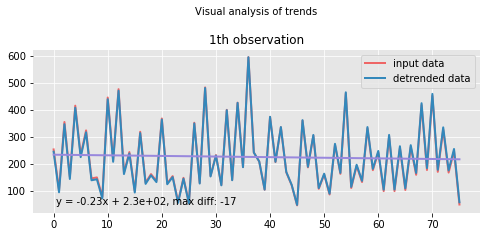

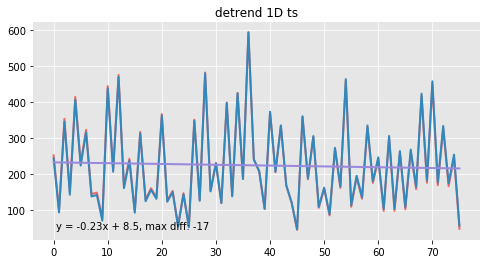

In [46]:
rg = pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

In [ ]:
rg.df_fullts.plot()

In [ ]:
#rg.df_fullts

Now we change the traintest method to LOO (leave one out)

In [ ]:
method = 'leave_1'
rg = pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

Now some prediction for a summer month. We will take lag JJA and prediction for September

In [ ]:
data = data_prep(moz_data, [9, 10], [31, 32], [-19, -18])
xarray(data).to_netcdf(os.path.join(data_path, 'rainfall_moz_910.nc'))

In [ ]:
# directory of target variable data
TV_path = os.path.join(data_path, 'rainfall_moz_910.nc')

# directory of precursor data
prec_path = os.path.join(data_path,'sst_1950-2020_1_12_monthly_1.0deg.nc')

# directory for test data 
path_test = os.path.join(my_main_dir, 'test')

# directory for output
output_path = os.path.join(my_main_dir, 'out')

list_of_name_path = [(1, TV_path), ('sst', prec_path)]

In [ ]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 500
min_area_in_degrees2 = 5
tfreq = None
start_end_year = (1983, 2020)
start_end_TVyear = (1983, 2020)
TVdates_aggr = True
ext_annual_to_mon = False 
method = 'random_5'
detrend = True
labels = True
pred_type = 'continuous'
q = 0.6
name = 'rainfall'
#lags = np.array([['07-01', '09-01'], ['10-01', '12-01']])            # numpy array of lags
#periodnames = ['JAS', 'NOD']                                         # names of the lags defined in the line above
#start_end_TVdate = ('01-01', '01-03')                                # tuple of start and end date of target variable


lags = np.array([['06-01', '08-01']])            
periodnames = ['JJA']                                         
start_end_TVdate = ('09-01', '10-01')    

In [ ]:
rg = pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

# Tete predictions

In [ ]:
# Tete_OND
tete_ond = data_prep(moz_data, [10, 11, 12], [30.21215, 35.346607], [-17.70114, -13.9988])
xarray(tete_ond).to_netcdf(os.path.join(data_path, 'tete_ond.nc'))

# Tete_JFM
tete_jfm = data_prep(moz_data, [1, 2, 3], [30.21215, 35.346607], [-17.70114, -13.9988])
xarray(tete_jfm).to_netcdf(os.path.join(data_path, 'tete_jfm.nc'))

### Predictions for OND

In [ ]:
# directory of target variable data
TV_path = os.path.join(data_path, 'tete_ond.nc')

# directory of precursor data
prec_path = os.path.join(data_path,'sst_1950-2020_1_12_monthly_1.0deg.nc')

# directory for test data 
path_test = os.path.join(my_main_dir, 'test')

# directory for output
output_path = os.path.join(my_main_dir, 'out')

list_of_name_path = [(1, TV_path), ('sst', prec_path)]

In [ ]:
tete_ond

We have data from 01-10-1981 until 01-12-2020, so we need sst data from 1981-2020

In [ ]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 400
min_area_in_degrees2 = 5
tfreq = None
start_end_year = (1981, 2020)
start_end_TVyear = (1981, 2020)
TVdates_aggr = True
ext_annual_to_mon = False 
method = 'leave_1'
detrend = True
labels = True
pred_type = 'continuous'
q = 0.6
name = 'rainfall'


lags = np.array([['04-01', '07-01']])            
periodnames = ['AMJJ']                                         
start_end_TVdate = ('10-01', '12-01')    

In [ ]:
rg_tete_ond = pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### Predictions for JFM

In [ ]:
# directory of target variable data
TV_path = os.path.join(data_path, 'tete_jfm.nc')

# directory of precursor data
prec_path = os.path.join(data_path,'sst_1950-2020_1_12_monthly_1.0deg.nc')

# directory for test data 
path_test = os.path.join(my_main_dir, 'test')

# directory for output
output_path = os.path.join(my_main_dir, 'out')

list_of_name_path = [(1, TV_path), ('sst', prec_path)]

In [ ]:
tete_jfm

We have data from 01-01-1981 until 01-03-2021 so we need sst data from 1980-2020 (to predict JFM 1981 we need AMJJ data from 1980) -> missing data in march 1981 so we use data from 01-01-1982 until 01-03-2021 so sst data from 1981 to 2020

We set this up by setting start_end_year = (1981, 2020) (so the start and end year of precursor data) and start_end_TVyear = (1982, 2021) (the start and end year of target variable, rainfall, data)

In [ ]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 500
min_area_in_degrees2 = 5
tfreq = None
start_end_year = (1981, 2020)
start_end_TVyear = (1982, 2021)
TVdates_aggr = True
ext_annual_to_mon = False 
method = 'leave_1'
detrend = True
labels = True
pred_type = 'continuous'
q = 0.6
name = 'rainfall'

lags = np.array([['04-01', '07-01']])            
periodnames = ['AMJJ']                                         
start_end_TVdate = ('01-01', '03-01')    

In [ ]:
rg_tete_jfm = pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### Gaza predictions

In [58]:
# Gaza_OND
gaza_ond = data_prep(moz_data, [10, 11, 12], [31.30631, 34.47342], [-25.38095, -21.30902])
xarray(gaza_ond).to_netcdf(os.path.join(data_path, 'gaza_ond.nc'))


# Gaza_JFM
gaza_jfm = data_prep(moz_data, [1, 2, 3], [31.30631, 34.47342], [-25.38095, -21.30902])
xarray(gaza_jfm).to_netcdf(os.path.join(data_path, 'gaza_jfm.nc'))

#### Predictions for OND

In [59]:
# directory of target variable data
TV_path = os.path.join(data_path, 'gaza_ond.nc')

# directory of precursor data
prec_path = os.path.join(data_path,'sst_1950-2020_1_12_monthly_1.0deg.nc')

# directory for test data 
path_test = os.path.join(my_main_dir, 'test')

# directory for output
output_path = os.path.join(my_main_dir, 'out')

list_of_name_path = [(1, TV_path), ('sst', prec_path)]

In [60]:
gaza_ond

,rainfall
1981-10-01,125.947765
1981-11-01,210.537420
1981-12-01,220.338422
1982-10-01,48.039336
1982-11-01,73.334244
...,...
2019-11-01,91.897970
2019-12-01,129.246573
2020-10-01,59.249753
2020-11-01,109.079426


We have data from 01-10-1981 until 01-12-2020, so we need sst data from 1981-2020

In [61]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 500
min_area_in_degrees2 = 5
tfreq = None
start_end_year = (1981, 2020)
start_end_TVyear = (1981, 2020)
TVdates_aggr = True
ext_annual_to_mon = False 
method = 'leave_1'
detrend = True
labels = True
pred_type = 'continuous'
q = 0.6
name = 'rainfall'


lags = np.array([['04-01', '07-01']])            
periodnames = ['AMJJ']                                         
start_end_TVdate = ('10-01', '12-01')    

Start linear detrending ...
Done
Visual test on 0th observationLoaded pre-processed data of sst

[1981 2020] ('04-01', '07-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(39dp, 97%)

Plotting Corr maps sst, split 0, lag AMJJ
Plotting Corr maps sst_labels_init, split 0, lag AMJJ

Getting MI timeseries
There are [6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 7, 8, 6, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8] regions in total (list of different splits)


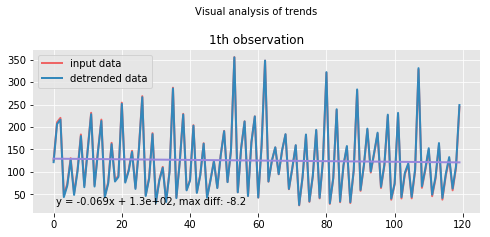

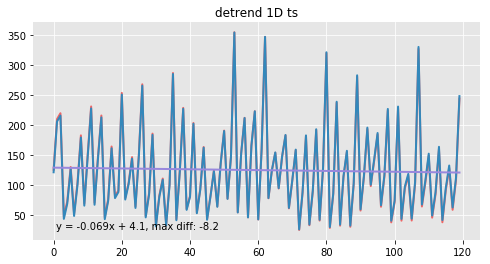

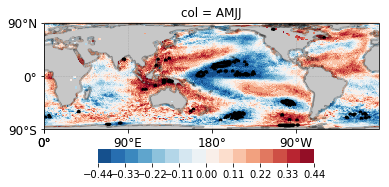

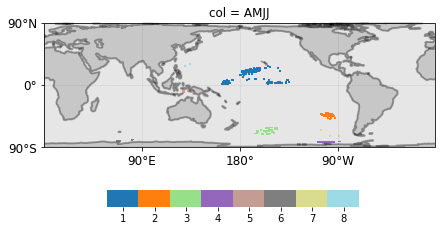

In [62]:
rg_gaza_ond = pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

#### Predictions for JFM

In [63]:
# directory of target variable data
TV_path = os.path.join(data_path, 'gaza_jfm.nc')

# directory of precursor data
prec_path = os.path.join(data_path,'sst_1950-2020_1_12_monthly_1.0deg.nc')

# directory for test data 
path_test = os.path.join(my_main_dir, 'test')

# directory for output
output_path = os.path.join(my_main_dir, 'out')

list_of_name_path = [(1, TV_path), ('sst', prec_path)]

In [64]:
gaza_jfm

,rainfall
1981-01-01,121.104830
1981-02-01,183.056839
1981-03-01,NaN
1982-01-01,217.654656
1982-02-01,241.436140
...,...
2020-02-01,311.183321
2020-03-01,291.331738
2021-01-01,431.399963
2021-02-01,594.332948


We have data from 01-01-1981 until 01-03-2021 so we need sst data from 1980-2020 (to predict JFM 1981 we need AMJJ data from 1980) -> missing data in March 1981 so we use data from 01-01-1982 until 01-03-2021 so sst data from 1981 to 2020

We set this up by setting start_end_year = (1981, 2020) (so the start and end year of precursor data) and start_end_TVyear = (1982, 2021) (the start and end year of target variable, rainfall, data)

In [65]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 500
min_area_in_degrees2 = 5
tfreq = None
start_end_year = (1981, 2020)
start_end_TVyear = (1982, 2021)
TVdates_aggr = True
ext_annual_to_mon = False 
method = 'leave_1'
detrend = True
labels = True
pred_type = 'continuous'
q = 0.6
name = 'rainfall'

lags = np.array([['04-01', '07-01']])            
periodnames = ['AMJJ']                                         
start_end_TVdate = ('01-01', '03-01')    

Start linear detrending ...
Done
Visual test on 0th observationLoaded pre-processed data of sst

[1981 2020] ('04-01', '07-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(39dp, 97%)

Plotting Corr maps sst, split 0, lag AMJJ
Plotting Corr maps sst_labels_init, split 0, lag AMJJ

Getting MI timeseries
There are [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 8, 10, 11, 12, 11, 11, 11, 11, 11, 11, 12, 11, 10, 12, 11, 11, 11, 11, 10, 11, 11, 11, 12] regions in total (list of different splits)


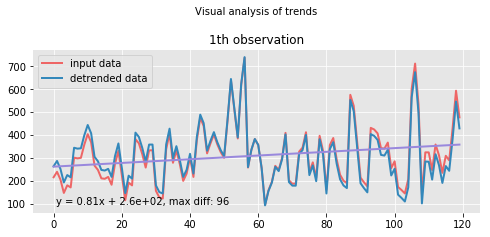

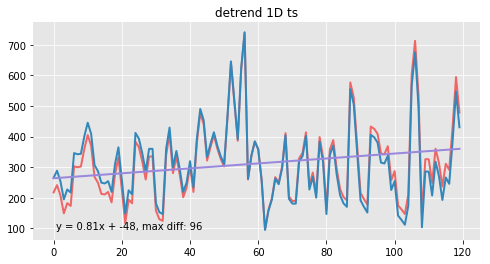

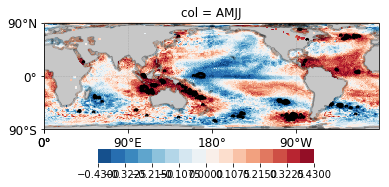

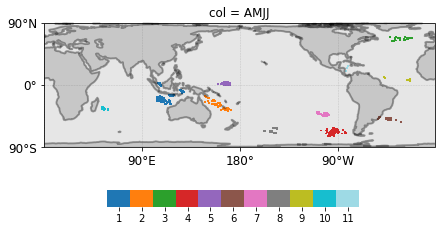

In [66]:
rg_gaza_jfm = pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### More results for OND Tete

In [67]:
# directory of target variable data
TV_path = os.path.join(data_path, 'tete_ond.nc')

# directory of precursor data
prec_path = os.path.join(data_path,'sst_1950-2020_1_12_monthly_1.0deg.nc')

# directory for test data 
path_test = os.path.join(my_main_dir, 'test')

# directory for output
output_path = os.path.join(my_main_dir, 'out')

list_of_name_path = [(1, TV_path), ('sst', prec_path)]

####  using AMJ

In [68]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 500
min_area_in_degrees2 = 5
tfreq = None
start_end_year = (1981, 2020)
start_end_TVyear = (1981, 2020)
TVdates_aggr = True
ext_annual_to_mon = False 
method = 'leave_1'
detrend = True
labels = True
pred_type = 'continuous'
q = 0.6
name = 'rainfall'


lags = np.array([['04-01', '06-01']])            
periodnames = ['AMJ']                                         
start_end_TVdate = ('10-01', '12-01')    

Start linear detrending ...
Done
Visual test on 0th observationLoaded pre-processed data of sst

[1981 2020] ('04-01', '06-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(39dp, 97%)



C:\Users\alicj\Documents\GitHub\RGCPD\RGCPD\find_precursors.py:349: RuntimeWarning: Mean of empty slice.
  totalsize_lag0 = area_grid[prec_labels_s[0]!=0].mean() / 1E5
C:\Users\alicj\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Plotting Corr maps sst, split 0, lag AMJ
no sst regions that pass distance_eps and min_area_in_degrees2 citeria

Getting MI timeseries
No precursor regions significant


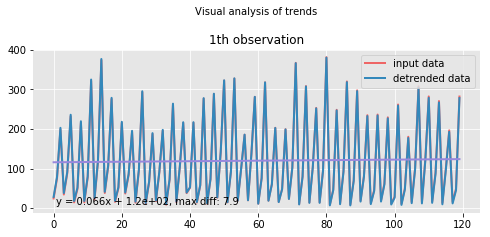

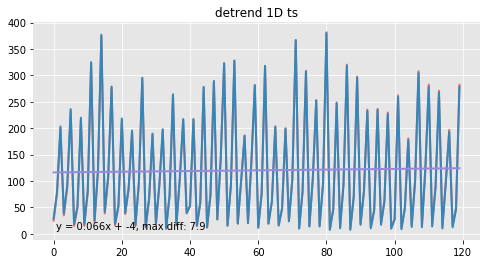

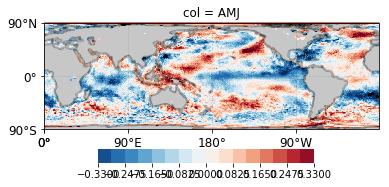

In [69]:
rg_tete_ond_amj = pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

In [70]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 500
min_area_in_degrees2 = 5
tfreq = None
start_end_year = (1981, 2020)
start_end_TVyear = (1981, 2020)
TVdates_aggr = True
ext_annual_to_mon = False 
method = 'leave_1'
detrend = True
labels = True
pred_type = 'continuous'
q = 0.6
name = 'rainfall'


lags = np.array([['05-01', '07-01']])            
periodnames = ['MJJ']                                         
start_end_TVdate = ('10-01', '12-01')    

Start linear detrending ...
Done
Visual test on 0th observationLoaded pre-processed data of sst

[1981 2020] ('05-01', '07-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(39dp, 97%)

Plotting Corr maps sst, split 0, lag MJJ
Plotting Corr maps sst_labels_init, split 0, lag MJJ

Getting MI timeseries
There are [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] regions in total (list of different splits)


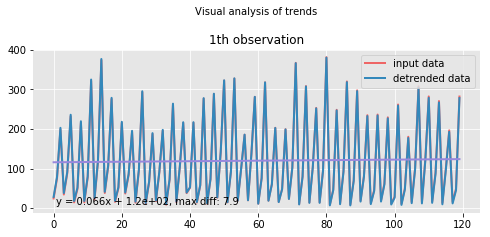

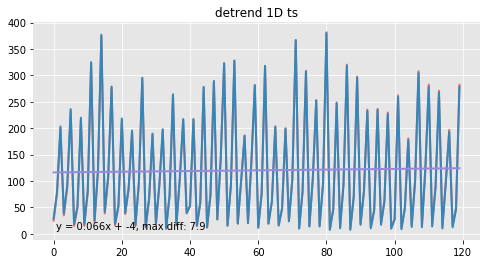

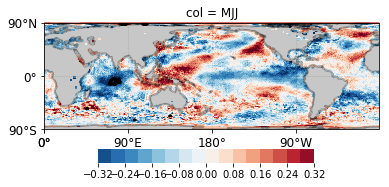

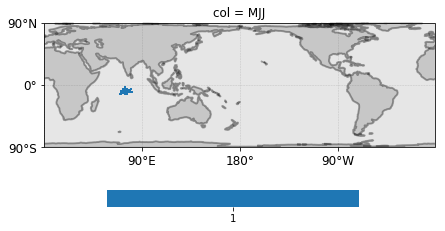

In [71]:
rg_tete_ond_mjj = pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

## Trying single month lags for Tete OND

### April

In [49]:
# Tete_OND
tete_ond = data_prep(moz_data, [10, 11, 12], [30.21215, 35.346607], [-17.70114, -13.9988])
xarray(tete_ond).to_netcdf(os.path.join(data_path, 'tete_ond.nc'))

In [50]:
tete_ond

,rainfall
1981-10-01,25.034958
1981-11-01,75.643328
1981-12-01,199.468212
1982-10-01,34.940176
1982-11-01,88.222450
...,...
2019-11-01,99.371082
2019-12-01,196.968677
2020-10-01,16.278833
2020-11-01,49.726872


In [51]:
# directory of target variable data
TV_path = os.path.join(data_path, 'tete_ond.nc')

# directory of precursor data
prec_path = os.path.join(data_path,'sst_1950-2020_1_12_monthly_1.0deg.nc')

# directory for test data 
path_test = os.path.join(my_main_dir, 'test')

# directory for output
output_path = os.path.join(my_main_dir, 'out')

list_of_name_path = [(1, TV_path), ('sst', prec_path)]

In [52]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 400
min_area_in_degrees2 = 5
tfreq = None
start_end_year = (1981, 2020)
start_end_TVyear = (1981, 2020)
TVdates_aggr = True
ext_annual_to_mon = False 
method = 'leave_1'
detrend = True
labels = True
pred_type = 'continuous'
q = 0.6
name = 'rainfall'


lags = np.array([['04-01']])            
periodnames = ['April']                                         
start_end_TVdate = ('10-01', '12-01')    

Start linear detrending ...
Done
Visual test on 0th observationLoaded pre-processed data of sst

[1981 2020] ('04-01', '04-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(39dp, 97%)

Plotting Corr maps sst, split 0, lag April
Plotting Corr maps sst_labels_init, split 0, lag April

Getting MI timeseries
There are [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] regions in total (list of different splits)


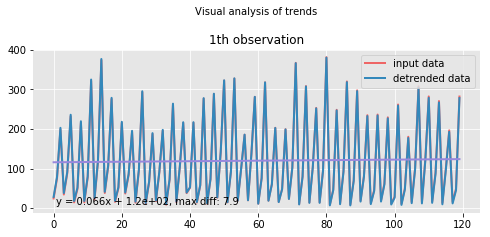

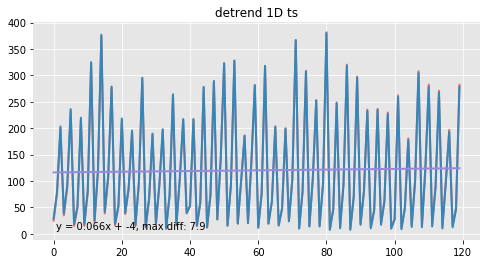

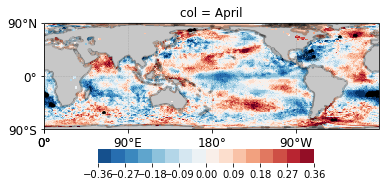

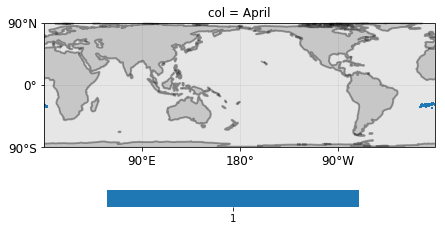

In [53]:
rg_tete_ond_april = pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### May 

In [54]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 400
min_area_in_degrees2 = 5
tfreq = None
start_end_year = (1981, 2020)
start_end_TVyear = (1981, 2020)
TVdates_aggr = True
ext_annual_to_mon = False 
method = 'leave_1'
detrend = True
labels = True
pred_type = 'continuous'
q = 0.6
name = 'rainfall'


lags = np.array([['05-01']])            
periodnames = ['May']                                         
start_end_TVdate = ('10-01', '12-01')    

Start linear detrending ...
Done
Visual test on 0th observationLoaded pre-processed data of sst

[1981 2020] ('05-01', '05-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(39dp, 97%)

Plotting Corr maps sst, split 0, lag May
Plotting Corr maps sst_labels_init, split 0, lag May

Getting MI timeseries
There are [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] regions in total (list of different splits)


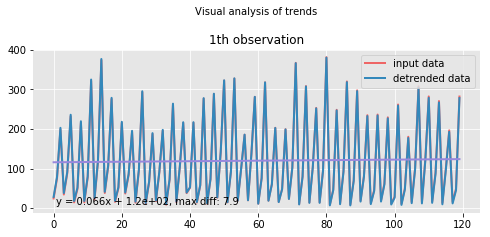

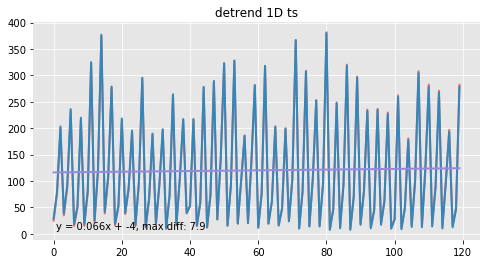

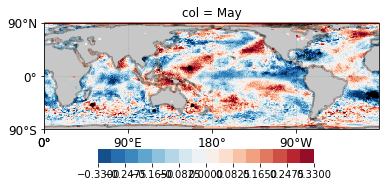

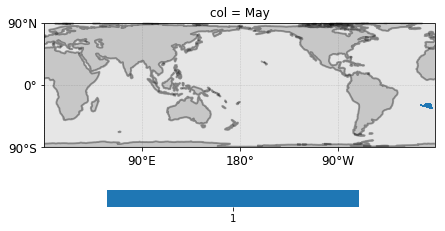

In [55]:
rg_tete_ond_may = pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### June

In [56]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 400
min_area_in_degrees2 = 5
tfreq = None
start_end_year = (1981, 2020)
start_end_TVyear = (1981, 2020)
TVdates_aggr = True
ext_annual_to_mon = False 
method = 'leave_1'
detrend = True
labels = True
pred_type = 'continuous'
q = 0.6
name = 'rainfall'


lags = np.array([['06-01']])            
periodnames = ['June']                                         
start_end_TVdate = ('10-01', '12-01')    

Start linear detrending ...
Done
Visual test on 0th observationLoaded pre-processed data of sst

[1981 2020] ('06-01', '06-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(39dp, 97%)

Plotting Corr maps sst, split 0, lag June
Plotting Corr maps sst_labels_init, split 0, lag June

Getting MI timeseries
There are [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] regions in total (list of different splits)


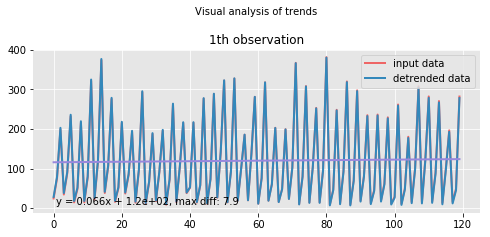

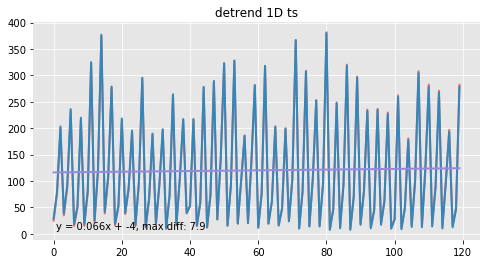

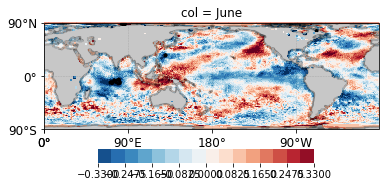

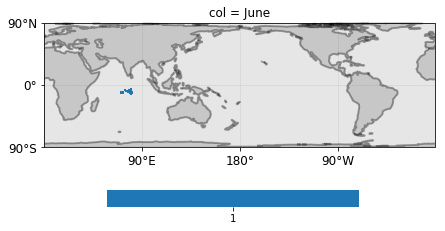

In [57]:
rg_tete_ond_june = pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### July

In [58]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 400
min_area_in_degrees2 = 5
tfreq = None
start_end_year = (1981, 2020)
start_end_TVyear = (1981, 2020)
TVdates_aggr = True
ext_annual_to_mon = False 
method = 'leave_1'
detrend = True
labels = True
pred_type = 'continuous'
q = 0.6
name = 'rainfall'


lags = np.array([['07-01']])            
periodnames = ['July']                                         
start_end_TVdate = ('10-01', '12-01')    

Start linear detrending ...
Done
Visual test on 0th observationLoaded pre-processed data of sst

[1981 2020] ('07-01', '07-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(39dp, 97%)

Plotting Corr maps sst, split 0, lag July
Plotting Corr maps sst_labels_init, split 0, lag July

Getting MI timeseries
There are [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] regions in total (list of different splits)


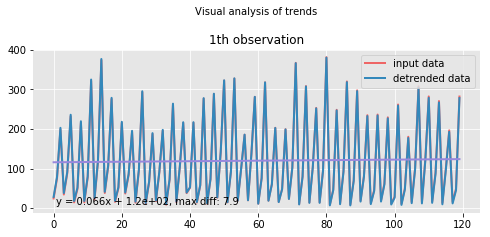

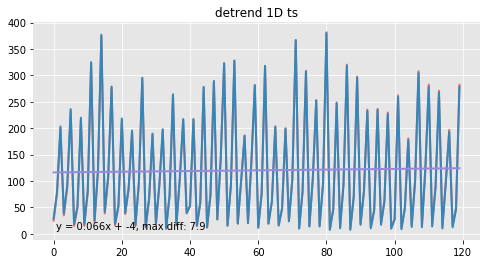

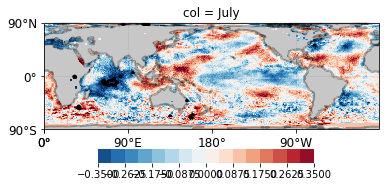

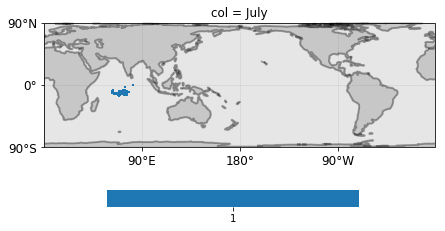

In [59]:
rg_tete_ond_july = pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

# Working with new data

In [59]:
def coordinates_2(data, lon, lat):
    lon_min = lon[0]
    lon_max = lon[1]
    lat_min = lat[0]
    lat_max = lat[1]
    
    # latitude
    data1 = data[data.iloc[:,1] <= lat_max][data[data.iloc[:,1] <= lat_max].iloc[:,1] >= lat_min]
    
    # longitude
    data2 = data1[data1.iloc[:,0] <= lon_max][data1[data1.iloc[:,0] <= lon_max].iloc[:,0] >= lon_min]
    
    return data2

In [60]:
data = pd.read_csv(os.path.join(data_path, 'JFM.X1981_X2020.csv'))

In [61]:
data.columns[2:]

Index(['X1981', 'X1982', 'X1983', 'X1984', 'X1985', 'X1986', 'X1987', 'X1988',
       'X1989', 'X1990', 'X1991', 'X1992', 'X1993', 'X1994', 'X1995', 'X1996',
       'X1997', 'X1998', 'X1999', 'X2000', 'X2001', 'X2002', 'X2003', 'X2004',
       'X2005', 'X2006', 'X2007', 'X2008', 'X2009', 'X2010', 'X2011', 'X2012',
       'X2013', 'X2014', 'X2015', 'X2016', 'X2017', 'X2018', 'X2019', 'X2020'],
      dtype='object')

In [62]:
columns = ['Var1', 'Var2']
for year in data.columns[2:]:
    columns.append(year[1:])

In [63]:
data.columns = columns

### Tete JFM

In [64]:
tete_jfm = coordinates_2(data, [30.21215, 35.346607], [-17.70114, -13.9988])
tete_jfm

,Var1,Var2,1981,1982,1983,1984,1985,1986,1987,1988,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
14807,30.225,-14.025,527,636,473,493,619,611,421,701,...,452,594,543,537,584,466,794,457,466,504
14808,30.275,-14.025,523,640,474,490,613,606,419,709,...,439,598,534,534,591,449,805,448,462,520
14809,30.325,-14.025,518,641,447,488,584,631,413,721,...,431,595,500,515,571,439,793,492,452,520
14810,30.375,-14.025,520,648,483,528,589,664,421,750,...,440,596,494,518,564,438,799,485,455,522
14811,30.425,-14.025,530,650,470,525,594,685,424,742,...,448,618,501,518,582,461,810,508,471,524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29207,35.125,-17.675,348,488,297,519,587,491,242,568,...,448,509,480,470,421,276,656,513,801,421
29208,35.175,-17.675,394,538,326,594,651,548,264,652,...,505,557,522,513,463,317,734,565,889,474
29209,35.225,-17.675,420,569,345,629,662,634,316,699,...,544,605,537,549,485,341,752,610,935,496
29210,35.275,-17.675,436,609,325,632,651,618,314,682,...,538,606,550,541,488,337,736,609,936,493


In [65]:
tete_jfm_data = data_steps(tete_jfm, 'rainfall')

In [66]:
tete_jfm_xr = xarray(tete_jfm_data)

In [67]:
tete_jfm_xr.to_netcdf(os.path.join(data_path, 'JFM_tete.nc'))

In [68]:
# directory of target variable data
TV_path = os.path.join(data_path, 'JFM_tete.nc')
# directory of precursor data
prec_path = os.path.join(data_path,'sst_1950-2020_1_12_monthly_1.0deg.nc')

# directory for test data 
path_test = os.path.join(my_main_dir, 'test')

# directory for output
output_path = os.path.join(my_main_dir, 'out')

list_of_name_path = [(1, TV_path), ('sst', prec_path)]

In [69]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 500
min_area_in_degrees2 = 5
tfreq = None
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)
TVdates_aggr = False
ext_annual_to_mon = False 
method = 'leave_1'
detrend = True
labels = True
pred_type = 'continuous'
q = 0.6
name = 'rainfall'


lags = np.array([['10-01', '12-01']])            
periodnames = ['OND']                                         
start_end_TVdate = ('01-01', '03-01')  


Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

[1981 2019] ('10-01', '12-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(38dp, 97%)

Plotting Corr maps sst, split 0, lag OND
Plotting Corr maps sst_labels_init, split 0, lag OND

Getting MI timeseries
There are [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8] regions in total (list of different splits)


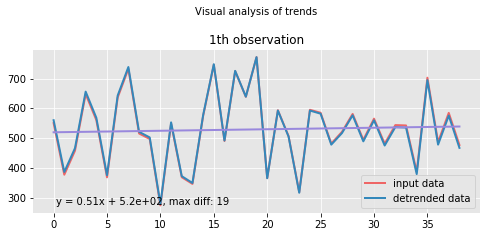

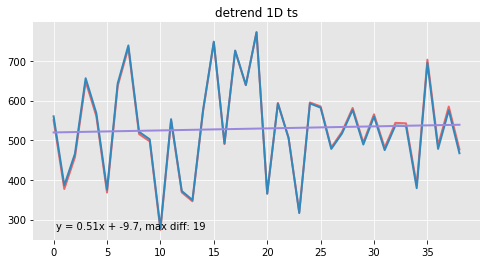

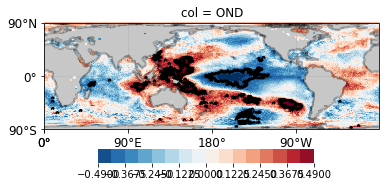

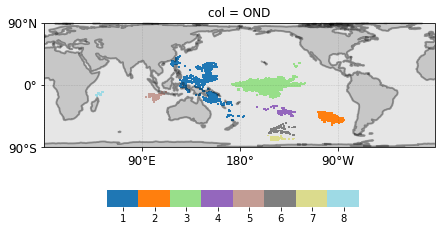

In [70]:
rg = pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

In [71]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 500
min_area_in_degrees2 = 5
tfreq = None
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)
TVdates_aggr = False
ext_annual_to_mon = False 
method = 'leave_1'
detrend = True
labels = True
pred_type = 'continuous'
q = 0.6
name = 'rainfall'


lags = np.array([['09-01', '10-01'], ['10-01', '12-01']])            
periodnames = ['SON', 'OND']                                         
start_end_TVdate = ('01-01', '03-01')  


Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

[1981 2019] ('09-01', '10-01')
[1981 2019] ('10-01', '12-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(38dp, 97%)

Plotting Corr maps sst, split 0, lag SON
Plotting Corr maps sst, split 0, lag OND
Plotting Corr maps sst_labels_init, split 0, lag SON
Plotting Corr maps sst_labels_init, split 0, lag OND

Getting MI timeseries
There are [17, 17, 17, 17, 17, 17, 18, 16, 17, 17, 16, 18, 16, 17, 17, 15, 17, 15, 17, 17, 16, 18, 17, 17, 17, 17, 17, 17, 17, 18, 17, 17, 17, 17, 16, 16, 17, 17, 17] regions in total (list of different splits)


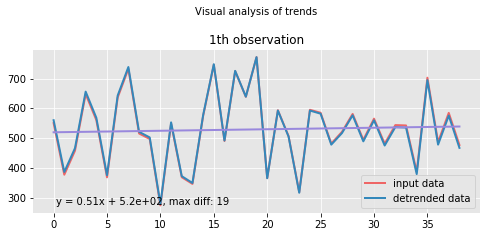

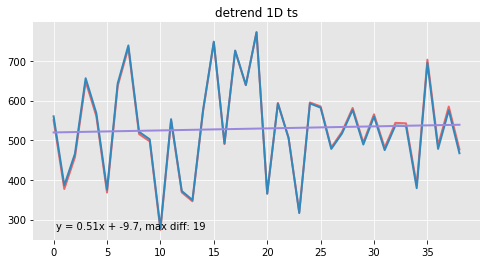

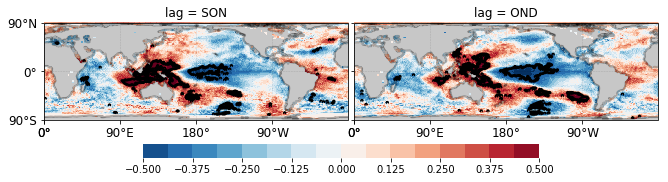

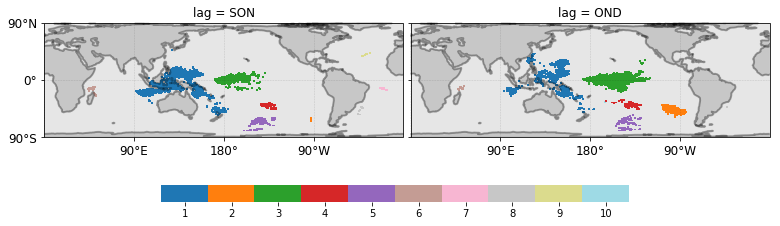

In [72]:
rg2 = pipeline(function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

In [35]:
data = pd.read_csv(os.path.join(data_path, 'rainfall_mozambique.csv'))

In [74]:
data_new = pd.read_csv(os.path.join(data_path, 'OND_1981_2020.csv'))

In [37]:
data_new.columns[2:]

Index(['X1981-12-01', 'X1982-12-01', 'X1983-12-01', 'X1984-12-01',
       'X1985-12-01', 'X1986-12-01', 'X1987-12-01', 'X1988-12-01',
       'X1989-12-01', 'X1990-12-01', 'X1991-12-01', 'X1992-12-01',
       'X1993-12-01', 'X1994-12-01', 'X1995-12-01', 'X1996-12-01',
       'X1997-12-01', 'X1998-12-01', 'X1999-12-01', 'X2000-12-01',
       'X2001-12-01', 'X2002-12-01', 'X2003-12-01', 'X2004-12-01',
       'X2005-12-01', 'X2006-12-01', 'X2007-12-01', 'X2008-12-01',
       'X2009-12-01', 'X2010-12-01', 'X2011-12-01', 'X2012-12-01',
       'X2013-12-01', 'X2014-12-01', 'X2015-12-01', 'X2016-12-01',
       'X2017-12-01', 'X2018-12-01', 'X2019-12-01', 'X2020-12-01'],
      dtype='object')

In [38]:
columns = ['Var1', 'Var2']
for year in data_new.columns[2:]:
    columns.append(year[1:])

In [39]:
data_new.columns = columns

In [40]:
data_new

,Var1,Var2,1981-12-01,1982-12-01,1983-12-01,1984-12-01,1985-12-01,1986-12-01,1987-12-01,1988-12-01,...,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,2019-12-01,2020-12-01
0,28.125,-29.875,217.626486,226.127264,307.799272,193.518708,368.934325,286.600658,258.191217,300.043222,...,199.778740,272.188394,242.395769,285.277119,105.265232,178.692944,219.191350,136.263567,149.401099,267.786145
1,28.375,-29.875,249.889325,229.444414,365.101942,235.756679,402.796263,332.334029,269.471585,370.880578,...,203.610426,318.192729,262.666686,306.724420,131.574216,213.035087,253.372575,156.327017,159.482754,282.075642
2,28.625,-29.875,229.560771,189.765923,328.692204,227.194309,381.979054,295.987285,234.962552,324.154204,...,162.644440,326.954633,243.144441,299.835207,128.204006,217.967745,257.805476,164.630600,169.678800,304.715319
3,28.875,-29.875,230.267495,194.114275,347.550590,223.986015,363.626912,293.221486,227.754490,334.985374,...,165.985374,339.637858,225.581599,288.566554,141.704403,229.735962,268.425058,178.292092,172.177856,301.683798
4,29.125,-29.875,244.691862,226.793611,416.464074,219.156046,452.893682,314.833004,286.183393,303.540969,...,189.293330,353.122416,250.913579,293.508506,155.379099,247.179453,295.273879,204.561403,210.577703,340.339835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4475,40.875,-10.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4476,41.125,-10.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4477,41.375,-10.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4478,41.625,-10.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
data = data_steps(data, 'rainfall')

In [42]:
data_new = data_steps(data_new, 'rainfall')

In [43]:
data_december = month(data, [12])
data_december

,rainfall
index,
1981-12-01,235.437381
1982-12-01,284.679043
1983-12-01,266.953734
1984-12-01,339.106935
1985-12-01,338.838227
1986-12-01,308.386852
1987-12-01,247.221837
1988-12-01,247.771117
1989-12-01,325.182331


In [44]:
data_new_december = month(data_new, [12])
data_new_december

,rainfall
index,
1981-12-01,235.437381
1982-12-01,284.679043
1983-12-01,266.953735
1984-12-01,339.106936
1985-12-01,338.838226
1986-12-01,308.386853
1987-12-01,247.221836
1988-12-01,247.771117
1989-12-01,325.182331


"""
    This is a forecasting pipeline function, which uses an RGCPD class object to make predictions for a target variable. It starts 
    by initializing RGCPD (which utilizes BivariateMI class), then it preprocess target variable and precursor(s), splits the data 
    into train and test, calculates correlation maps, cluster the regions together and make predictions. 
    (when I include multiple lags and feature selection add that to the description)

    Parameters
    -----------
    function : function from BivariateMI class
        Function to apply to calculate the bivariate mutual information, suggested: correlation maps (class_BivariateMI.corr_map)

    alpha : float
        Significance threshold, suggested: 0.05

    FDR_control : bool
        Control for multiple hypothesis testing, suggested: True

    distance_eps : int
        The maximum distance between two gridcells for one to be considered as in the neighborhood of the other, only gridcells 
        with the same sign are grouped together, suggested: 500

    min_area_in_degrees2 : int
        The number of samples gridcells in a neighborhood for a region to be considered as a core point. The parameter is proportional 
        to the average size of 1 by 1 degree gridcell, suggested: 5

    tfreq : int
        n-month means instead of n-day means, suggested: 10, if using time_mean_periods set tfreq to None

    start_end_year : tuple
        For computational efficiency load a subset of data in format (start_year, end_year), default is to load all years (start_end_year = None)

    TVdates_aggr : bool
        If True target variable will be aggregated to a single value per year (mean), if TVdates_aggr is True, set tfreq to None

    ext_annual_to_mon : bool
        If tfreq is None and target variable contain one-value-per-year, the target is extended to match the precursor time-axis. 
        If precursors are monthly means, then the target is also extended to monthly values, else daily values. Both are then 
        aggregated to {tfreq} day/monthly means.  The default is True

    method : str or bool
        Refers to the method to split train test, see class_RGCPD.py for options, suggested: random_5

    detrend : bool
        Refers to linear detrending, suggested: True

    labels : bool
        If true, quick_view_labels is executed on the RGCPD class object

    pred_type : str
        Type of prediction ("continuous" or "events")

    q : int
        Quantile threshold for event definition, suggested: 0.66
    
    lags : numpy array
        lag with respect to the target variable at which to calculate the MI, examples: np.array([1]), np.array([['01-01', '03-01']])
    
    periodnames : list, optional (recommended)
        List of lags names, to avoid lags naming set periodnames = None
    
    start_end_TVdate : tuple
        Tuple of start and end date of target variable ("start","end") = ("mm-dd","mm-dd")
        
    name : string
        String with name of the variable in nc file, e.g. name = 'rainfall'
        

    Returns
    -----------
    """